In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
import torch

# AE Kernel Convolutional Network (basic)

See https://docs.google.com/drawings/d/1NPbl-NJUYoE5vefHRkwR2GAVe20CPr59_VBQzncnflc/edit

## Basics

In [0]:
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1):
  s = images.shape

  assert len(s) == 3
  resolution = int(s[0] ** 0.5)
  fig, axs = plt.subplots(nrows=resolution, ncols=resolution, figsize=(30, 30),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

def generate_bouncing_pixel(width, height, count=100):
  ball_width = 2
  x = 3 #random.randint(0, width)
  y = 2 #random.randint(0, height)
  dx = -1 #random.randint(0, 2) - 1
  dy = 1 #random.randint(0, 2) - 1
  
  images = []
  for _ in range(count):
    image = np.zeros((width, height))
    image[x, y] = 1.0
    image[x+1, y] = 1.0
    image[x, y+1] = 1.0
    image[x+1, y+1] = 1.0

    #image=gaussian_filter(image, 0.5)
    images.append(image)
    x += dx
    y += dy
    if (x < 0 or x > width - 1 - (ball_width - 1)):
      dx *= -1
      x += dx
    if (y < 0 or y > height - 1 - (ball_width - 1)):
      dy *= -1
      y += dy

  return torch.as_tensor(images)

def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def convolve(image_width, image_height, kernel_width, kernel_height, stride):
  convolutions = []
  for x in range(0, image_width - kernel_width + 1, stride):
    for y in range(0, image_height - kernel_height + 1, stride):
      convolutions.append([y, x, y + kernel_height, x + kernel_width])

  return convolutions

def conv_slice(images, image_width, image_height, kernel_width, kernel_height, stride):
  convolutions = convolve(image_width, image_height, kernel_width, kernel_height, stride)
  slices = [images[i, c[0]:c[2], c[1]:c[3]] for i in range(images.shape[0]) for c in convolutions]

  slices = torch.stack(slices).float()
  slices = slices.view(slices.shape[0], -1).to(device)
  return slices


def conv_join(slices, image_count, image_width, image_height, kernel_width, kernel_height, stride):
  print("slices.shape", slices.shape)
  if len(slices.shape) == 2:
    slices = slices.view(image_count, int(slices.shape[0] / image_count), kernel_width, kernel_height)

  # slices is now (image count, convolutions, kernel size, kernel size)
  #print("slices.shape", slices.shape)

  convolutions = convolve(image_width, image_height, kernel_width, kernel_height, stride)
  assert len(convolutions) == slices.shape[1], f"{len(convolutions)} == {slices.shape[1]}?"

  buffer = torch.zeros((image_count, image_width, image_height)).to(device)
  #print("buffer", buffer.shape)

  for i in range(image_count):
    #if i == 0:
    #  print("slices[i]", slices[i])

    for x in range(image_width):
      for y in range(image_height):
        values = []
        for c in range(len(convolutions)):
          convolution = convolutions[c]
          if x >= convolution[0] and x < convolution[2] and y >= convolution[1] and y < convolution[3]:
            value = slices[i, c, x - convolution[0], y - convolution[1]]
            values.append(value.item())
            #if i == 0 and x == 3 and y == 3:
            #  print(f"x {x}, y {y}, convolution {convolution}")
            #  print(f"[{x - convolution[0]}, {y - convolution[1]}]", value)

        #if i == 0 and x == 3 and y == 3:
        #  print(f"i {i}, x {x}, y {y}")
        #  print("values", values)
        if len(values) > 0:
          value = np.average(values)
          #print("value", value)
          buffer[i, x, y] = value

  return buffer

def flatten_features(mu, image_count):
  a = int(mu.shape[1] ** 0.5)
  print("mu.shape", mu.shape)
  print("a", a)
  w = int(int(mu.shape[0] / image_count) ** 0.5)
  mu1 = mu.view(image_count, w, w, a , a)
  mu1 = mu1.permute(0, 1, 3, 2, 4)
  s = mu1.shape
  mu1 = mu1.contiguous().view(s[0], s[1] * s[2], s[3] * s[4])
  return mu1, a

def unflatten_features(h1, a):
  s = h1.shape
  print("unflatten 1: ", s)
  h = h1.view(s[0], int(s[1] / a), a, int(s[2] / a), a)
  print("unflatten 2: ", h.shape)
  h = h.permute(0, 1, 3, 2, 4)
  print("unflatten 3: ", h.shape)
  
  s = h.shape
  h = h.contiguous().view(s[0] * s[1] * s[2], s[3] * s[4])
  print("unflatten 4: ", h.shape)

  return h



## Unit


In [0]:
class VAE(nn.Module):
  def __init__(self, input_width, input_height, feature_count):
    super(VAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.feature_count = feature_count

    self.encoder = nn.Sequential(
      nn.Linear(input_width * input_height    , input_width * input_height * 2),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height * 4),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
    )

#     self.e_l1 = nn.Linear(input_width * input_height    , input_width * input_height * 2)
#     self.e_b1 = nn.BatchNorm1d(1)
#     self.e_r1 = nn.LeakyReLU(0.2, inplace=True)
#     self.e_l2 = nn.Linear(input_width * input_height * 2, input_width * input_height * 4)
#     self.e_b2 = nn.BatchNorm1d(1)
#     self.e_r2 = nn.LeakyReLU(0.2, inplace=True)
      
    self.decoder = nn.Sequential(
      nn.Linear(feature_count  , input_width * input_height * 2),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height),
      #nn.BatchNorm2d(1),
      nn.Sigmoid(),
    )

    self.linear_mu = nn.Linear(input_width * input_height * 4, feature_count)
    self.linear_sigma = nn.Linear(input_width * input_height * 4, feature_count)

    self.lrelu = nn.LeakyReLU()
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

  def encode(self, x):
    self.logger.debug(f"x {x.shape}")
    x = self.encoder(x)
#     x = self.e_l1(x)
#     #x = self.e_b1(x)
#     x = self.e_r1(x)
#     x = self.e_l2(x)
#     #x = self.e_b2(x)
#     x = self.e_r2(x)
    
    #return self.tanh(self.linear_mu(x)), self.tanh(self.linear_sigma(x))
    return self.sigmoid(self.linear_mu(x)), self.linear_sigma(x)

  def decode(self, z):
    #z = z.view(-1, 1, 1, self.feature_count)
    self.logger.debug(f"z {z.shape}")
    return self.decoder(z)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.FloatTensor(std.size()).normal_().to(device)
    eps = eps.mul(std).add_(mu)
    eps = torch.sigmoid(eps)
    self.logger.debug(f"eps {eps.shape}")

    return eps

  def decode_features(self, mu, logvar):
    z = self.reparametrize(mu, logvar)
    self.logger.debug(f"z {z.shape}")
    decoded = self.decode(z)
    self.logger.debug(f"decoded {decoded.shape}")
    return decoded, z

    
  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    mu, logvar = self.encode(x)
    self.logger.debug(f"mu {mu.shape}")
    self.logger.debug(f"logvar {logvar.shape}")
    
    decoded, z = self.decode_features(mu, logvar)
    return decoded, mu, logvar, z
  
  
class Unit(nn.Module):
  def __init__(self, name, image_width, image_height, kernel_width, kernel_height, feature_count, load_weights=True):
    super(Unit, self).__init__()
    self.name = name
    self.image_width = image_width
    self.image_height = image_height
    self.kernel_width = kernel_width
    self.kernel_height = kernel_height
    self.feature_count = feature_count
    self.a = int(self.feature_count ** 0.5)
    assert self.a * self.a == self.feature_count, "feature count must be a perfect square"

    self.vae = VAE(kernel_width, kernel_height, feature_count)
    self.trained = False
    
    if load_weights and os.path.exists(self.save_path()):
      self.load_state_dict(torch.load(self.save_path()))
      self.eval()
      self.trained = True

  def forward(self, x):
    return self.vae(x)

  def loss_function(self, recon_x, x, mu, logvar):
    # print(recon_x.size(), x.size())
    BCE = F.binary_cross_entropy(recon_x.view(-1, self.kernel_width * self.kernel_height), x.view(-1, self.kernel_width * self.kernel_height), size_average=True)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD
    BCE /= 0.00001
    #print(BCE, KLD)
    return BCE + KLD

  def train(self, images, stride=1, num_epochs=3000):
    if self.trained:
      return
    
    if isinstance(images, bool):
      return

    #print("images", images.shape)

    input = conv_slice(images, self.image_width, self.image_height, self.kernel_width, self.kernel_height, stride)
    #print("input", input.shape)
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)

    done = False
    dataset = torch.utils.data.TensorDataset(input)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

    epoch = 0

    with tqdm(total=num_epochs) as tqdm_epochs:
      for epoch in range(num_epochs):
        for i, batch in enumerate(data_loader):
          batch = batch[0].to(device)
          output, mu, logvar, z = self(batch)
          loss = self.loss_function(output, batch, mu, logvar)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        if epoch % int(num_epochs / 10) == 0:
          output, mu, logvar, z = self(input[0].unsqueeze(dim=0))
          tqdm_epochs.write('epoch [{}/{}], loss:{:.4f}'
               .format(epoch+1, num_epochs, loss.item()))
          show_image(output[0].view(self.kernel_height, self.kernel_width).detach(), title=f"output {0}", vmin=0, vmax=1)

        if (loss.item() < 0.001 and epoch > 1500) or epoch > num_epochs:
          break
          
        tqdm_epochs.update(1)

    torch.save(self.state_dict(), self.save_path())

  def join_slices_into_images(self, slices, image_count, stride):
    return conv_join(slices, image_count, self.image_width, self.image_height, self.kernel_width, self.kernel_height, stride)
    
  def eval_data(self, images, stride):
    # conv_slice(images) => slices
    input = conv_slice(images, self.image_width, self.image_height, self.kernel_width, self.kernel_height, stride)

    # decoder(encoder(slices)) => slices_bar
    slices_bar, mu, logvar, z = self(input)
    
    # conv_join(slices) => images
    images_bar = self.join_slices_into_images(slices_bar, images.shape[0], stride)

    return images_bar, slices_bar, mu, logvar, z
    
  def save_path(self):
    return f"unit_{self.name}.pt"
  
  # assumes 4 features
  def explore_latent_space(self, resolution=6):
    ls = torch.linspace(0, 1, resolution)

    test_mu = torch.stack([torch.tensor([ls[i1], ls[i2], ls[i3], ls[i4]]) for i1 in np.arange(resolution) for i2 in np.arange(resolution) for i3 in np.arange(resolution) for i4 in np.arange(resolution)]).to(device)
    test_logvar = torch.ones(test_mu.size()).mul(-10).to(device)

    output, _ = self.vae.decode_features(test_mu, test_logvar)
    output = output.view(-1, self.kernel_width, self.kernel_height)

    show_image_grid(output)
    
  def up(self, images1, stride=2):
    # encode(images) => mu
    _, _, mu1, _, _ = self.eval_data(images1, stride=stride)
    
    # flatten(mu) => images2
    images2, _ = flatten_features(mu1, image_count=images1.shape[0])
    print(images2.shape)
    show_image(images1[0].detach(), vmin=0, vmax=1, title="images1 0")
    show_image(images2[0].detach(), vmin=0, vmax=1, title="images2 0")
    images2 = images2.detach()
    return images2
  
  def down(self, images2_bar, stride=2):
    # unflatten(images2) => mu, varlog
    mu1_bar = unflatten_features(images2_bar, a=self.a).to(device)
    varlog_bar = torch.ones(mu1_bar.size()).mul(-10).to(device)

    # decode(mu, varlog) => slices
    slices1_bar, _ = unit1.vae.decode_features(mu1_bar, varlog_bar)
    slices1_bar = slices1_bar.view(-1, unit1.kernel_width, unit1.kernel_height).detach()
    slices1_bar.shape
    show_image(slices1_bar[20])
    print("images1.shape[0]", images1.shape[0])

    # conv_join(slices) => images
    slices1_bar = slices1_bar.view(images1.shape[0], -1, slices1_bar.shape[1], slices1_bar.shape[2])
    images1_bar = unit1.join_slices_into_images(slices1_bar, images1.shape[0], stride)

    return images1_bar

def build_and_train_unit(name, images, kernel_size, feature_count, stride, num_epochs=4000, load_weights=True):
  image_count, image_height, image_width = images.shape
  unit = Unit(name=name, image_width=image_width, image_height=image_height, kernel_width=kernel_size, kernel_height=kernel_size, feature_count=feature_count, load_weights=load_weights).to(device)
  unit.train(images, stride=stride, num_epochs=num_epochs)
  reconstructed_images, reconstructed_slices, mu, logvar, z = unit.eval_data(images, stride=stride)
  return unit, reconstructed_images, reconstructed_slices, mu, logvar, z




# Unit 1

In [10]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if False:
  import os
  import glob

  files = glob.glob('./*.pt')
  for f in files:
      os.remove(f)

# image_height = image_width = 16
# images1 = generate_bouncing_pixel(image_height, image_width, count=image_count)
images1 = next(iter(load_mnist(batch_size=10)))[0].squeeze(dim=1)
unit1, reconstructed_images1, reconstructed_slices1, mu1, logvar1, z1 = build_and_train_unit(name="1", images=images1, kernel_size=5, feature_count=4, stride=1, num_epochs=4000)

# for i in range(5):
#   print(f"------------------------- IMAGE {i} --------------------------")
#   show_image(images1[i].detach(), vmin=0, vmax=1, title=f"images1 image {i}")
#   show_image(reconstructed_images1[i].detach(), vmin=0, vmax=1, title=f"reconstructed_images1 {i}")
#   show_image(images1[i].float()-reconstructed_images1[i].detach().cpu(), title=f"diff1 {i}")

# unit1.explore_latent_space()

slices.shape torch.Size([5760, 25])


## Test unit1


slices.shape torch.Size([1440, 25])
------------------------- IMAGE 0 --------------------------


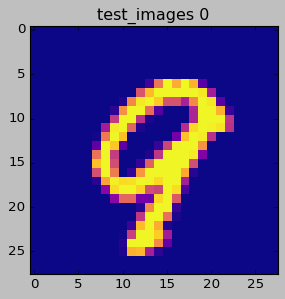

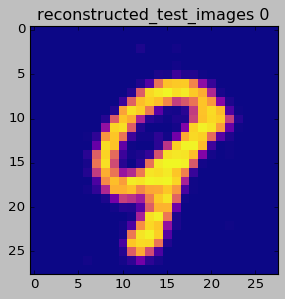

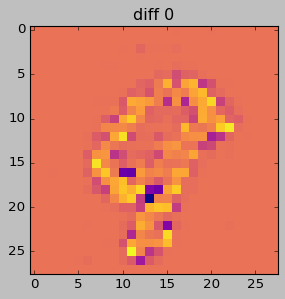

------------------------- IMAGE 1 --------------------------


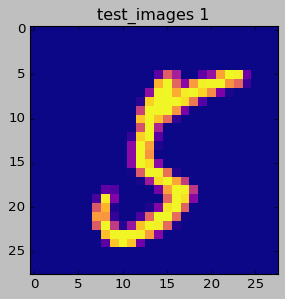

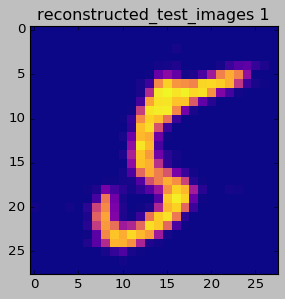

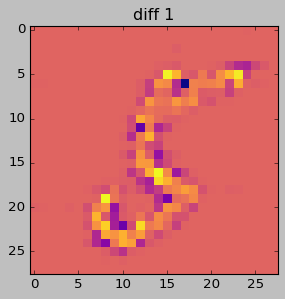

------------------------- IMAGE 2 --------------------------


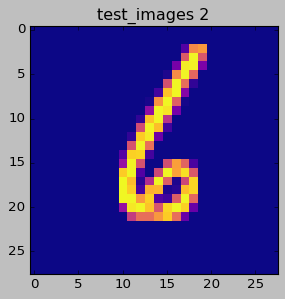

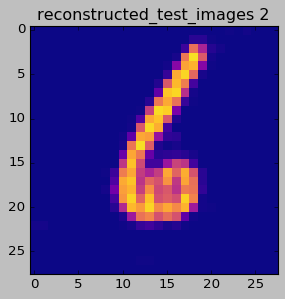

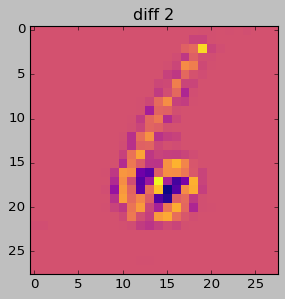

------------------------- IMAGE 3 --------------------------


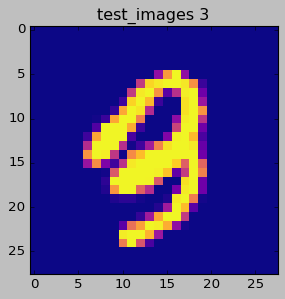

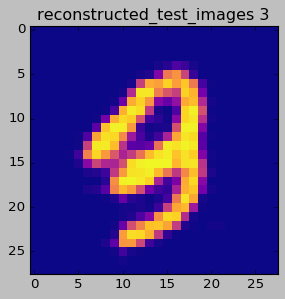

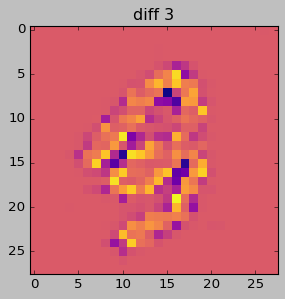

------------------------- IMAGE 4 --------------------------


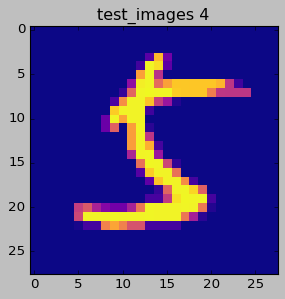

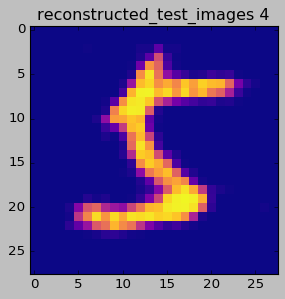

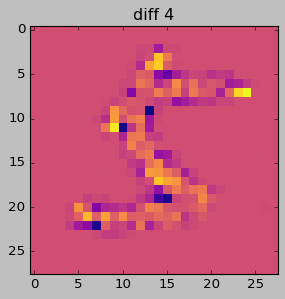

------------------------- IMAGE 5 --------------------------


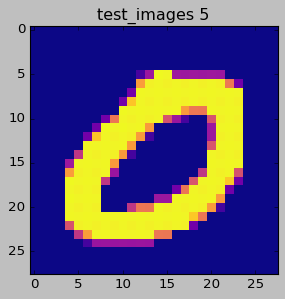

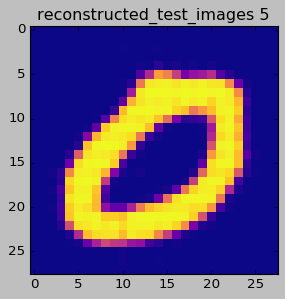

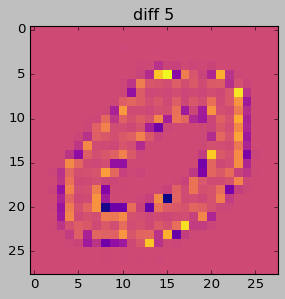

------------------------- IMAGE 6 --------------------------


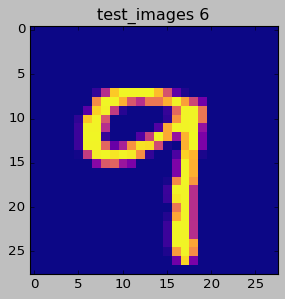

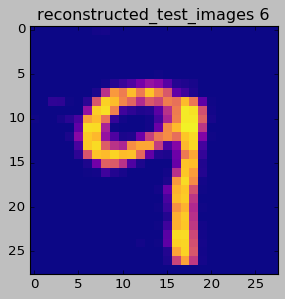

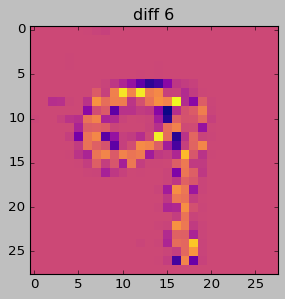

------------------------- IMAGE 7 --------------------------


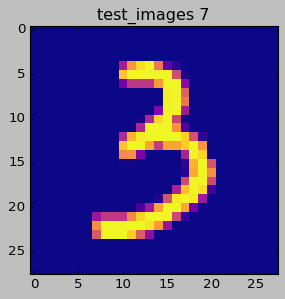

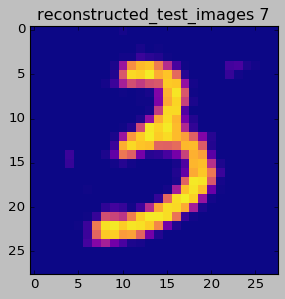

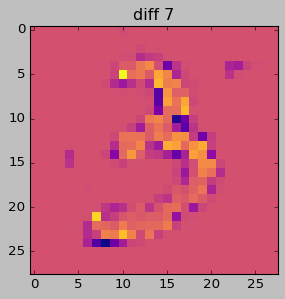

------------------------- IMAGE 8 --------------------------


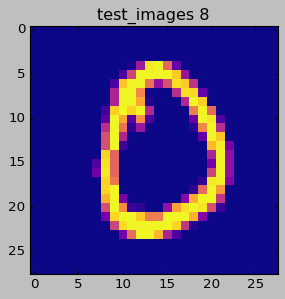

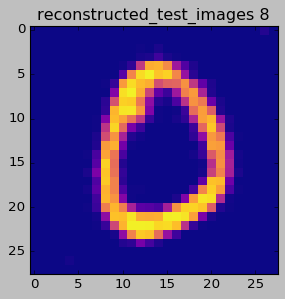

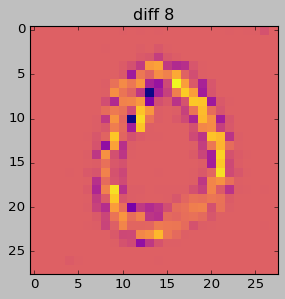

------------------------- IMAGE 9 --------------------------


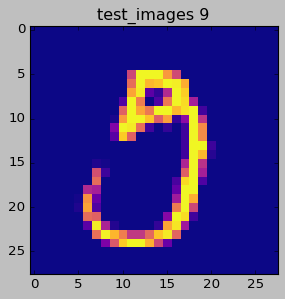

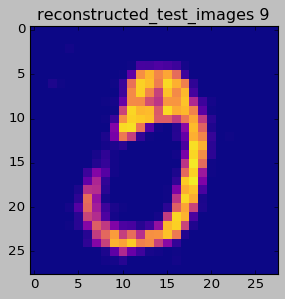

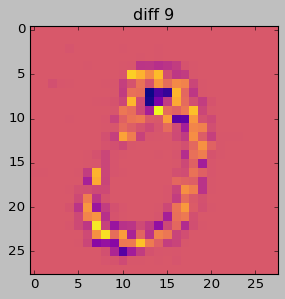

In [11]:
test_images = next(iter(load_mnist(batch_size=10)))[0].squeeze(dim=1)
reconstructed_test_images, _, _, _, _ = unit1.eval_data(test_images, stride=2)

for i in range(10):
  print(f"------------------------- IMAGE {i} --------------------------")
  show_image(test_images[i].detach(), vmin=0, vmax=1, title=f"test_images {i}")
  show_image(reconstructed_test_images[i].detach(), vmin=0, vmax=1, title=f"reconstructed_test_images {i}")
  show_image(test_images[i].float()-reconstructed_test_images[i].detach().cpu(), title=f"diff {i}")



## Prepare images2 as input for layer 2

Use stride>1 to pool

slices.shape torch.Size([1440, 25])
mu.shape torch.Size([1440, 4])
a 2
torch.Size([10, 24, 24])


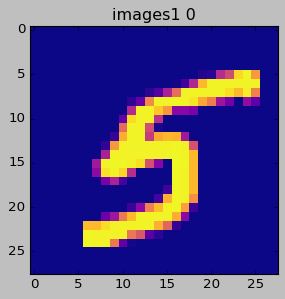

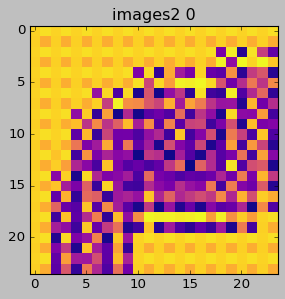

In [12]:
images2 = unit1.up(images1, stride=2)

# Layer 2

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/10000 [00:00<?, ?it/s]

epoch [1/10000], loss:69107.3203


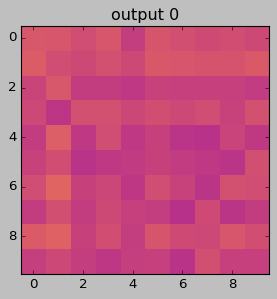

 10%|█         | 1000/10000 [00:27<04:07, 36.30it/s]

epoch [1001/10000], loss:57489.0742


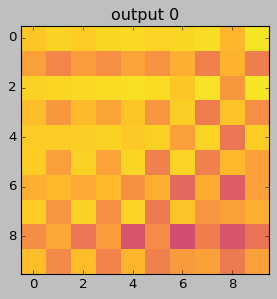

 20%|██        | 2000/10000 [00:54<03:31, 37.74it/s]

epoch [2001/10000], loss:55913.3203


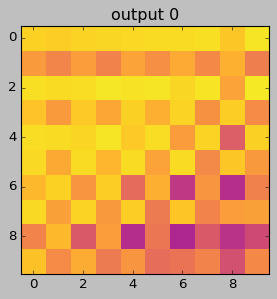

 30%|███       | 3000/10000 [01:22<03:10, 36.80it/s]

epoch [3001/10000], loss:54594.6797


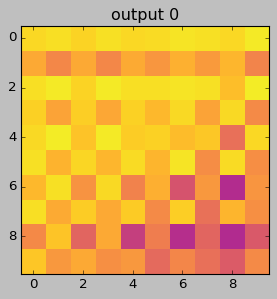

 40%|████      | 4000/10000 [01:49<02:44, 36.49it/s]

epoch [4001/10000], loss:53484.1875


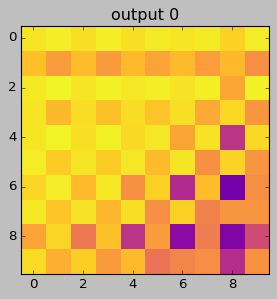

 50%|█████     | 5000/10000 [02:17<02:17, 36.29it/s]

epoch [5001/10000], loss:52454.6406


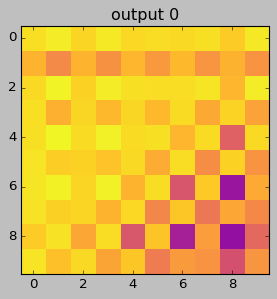

 60%|██████    | 6000/10000 [02:44<01:48, 36.85it/s]

epoch [6001/10000], loss:54100.7344


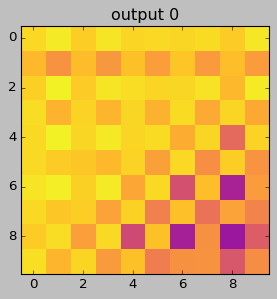

 70%|███████   | 7000/10000 [03:12<01:22, 36.50it/s]

epoch [7001/10000], loss:52628.7812


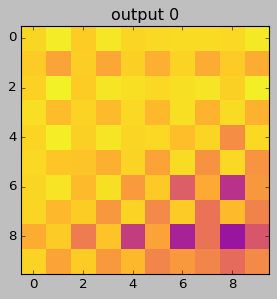

 80%|████████  | 8000/10000 [03:39<00:53, 37.46it/s]

epoch [8001/10000], loss:52302.1992


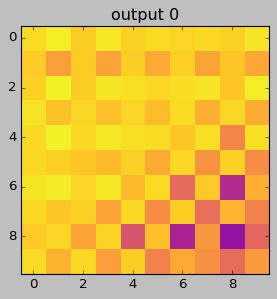

 90%|█████████ | 9000/10000 [04:06<00:26, 37.22it/s]

epoch [9001/10000], loss:51902.1914


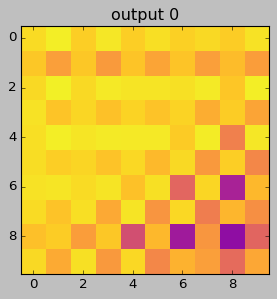

100%|██████████| 10000/10000 [04:34<00:00, 36.47it/s]


slices.shape torch.Size([640, 100])
------------------------- IMAGE 0 --------------------------


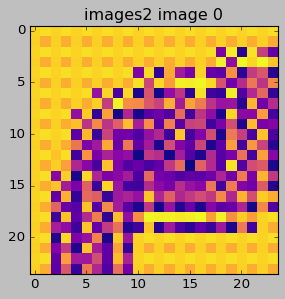

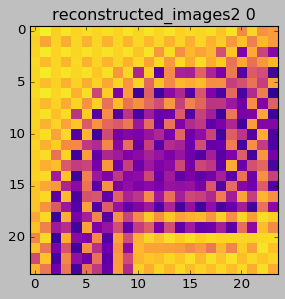

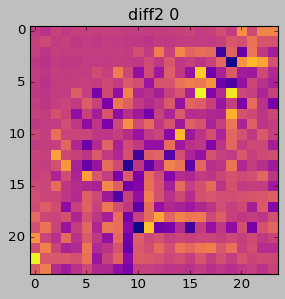

------------------------- IMAGE 1 --------------------------


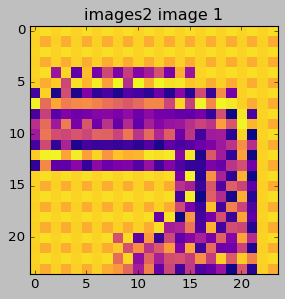

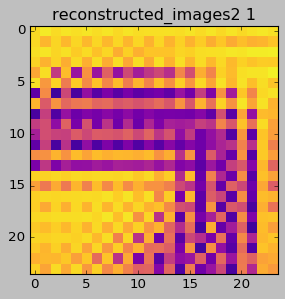

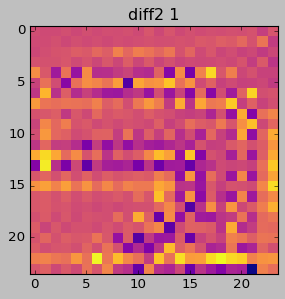

------------------------- IMAGE 2 --------------------------


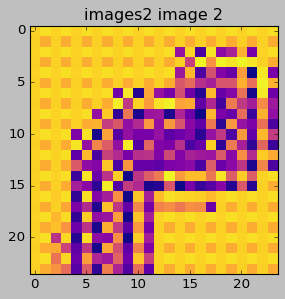

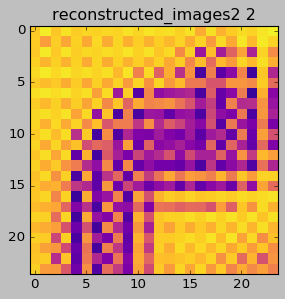

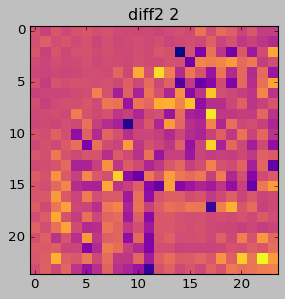

------------------------- IMAGE 3 --------------------------


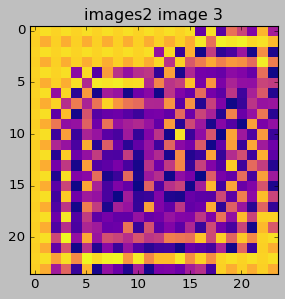

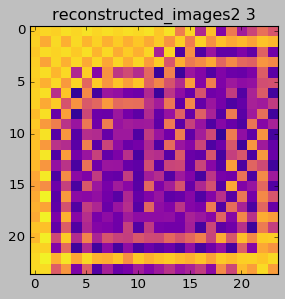

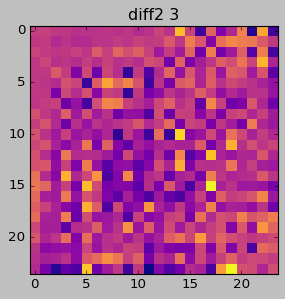

------------------------- IMAGE 4 --------------------------


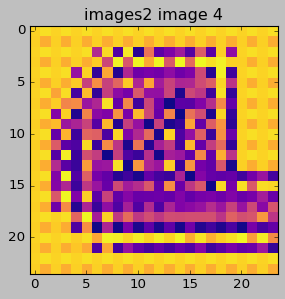

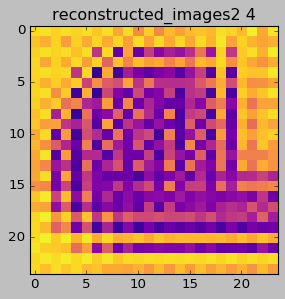

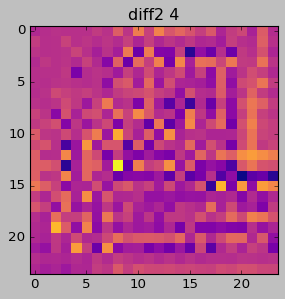

In [13]:
unit2, reconstructed_images2, reconstructed_slices2, mu2, logvar2, z2 = build_and_train_unit(name="2", images=images2, kernel_size=5 * 2, feature_count=4, stride=2, num_epochs=10000, load_weights=False)

for i in range(5):
  print(f"------------------------- IMAGE {i} --------------------------")
  show_image(images2[i].detach(), vmin=0, vmax=1, title=f"images2 image {i}")
  show_image(reconstructed_images2[i].detach(), vmin=0, vmax=1, title=f"reconstructed_images2 {i}")
  show_image(images2[i].float().cpu()-reconstructed_images2[i].detach().cpu(), title=f"diff2 {i}")

#unit2.explore_latent_space()

unflatten 1:  torch.Size([10, 24, 24])
unflatten 2:  torch.Size([10, 12, 2, 12, 2])
unflatten 3:  torch.Size([10, 12, 12, 2, 2])
unflatten 4:  torch.Size([1440, 4])


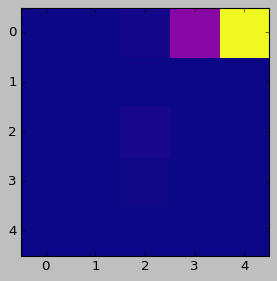

images1.shape[0] 10
slices.shape torch.Size([10, 144, 5, 5])
------------------------- IMAGE 0 --------------------------


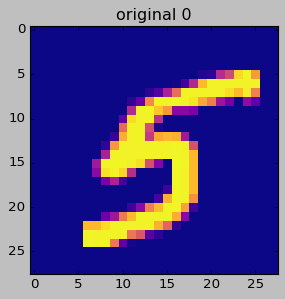

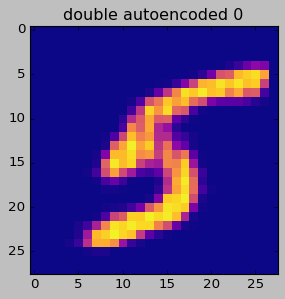

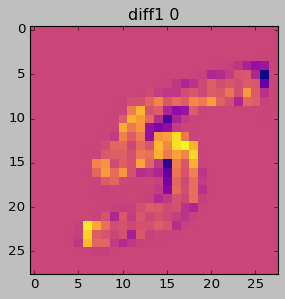

------------------------- IMAGE 1 --------------------------


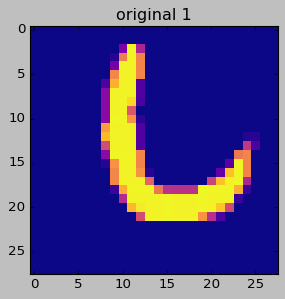

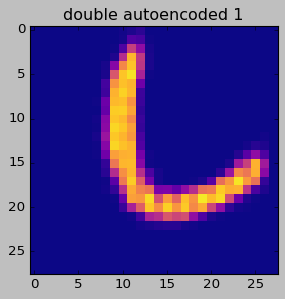

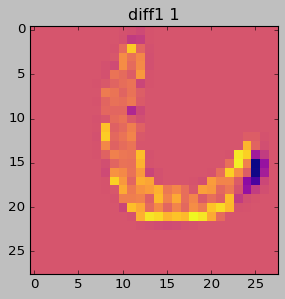

------------------------- IMAGE 2 --------------------------


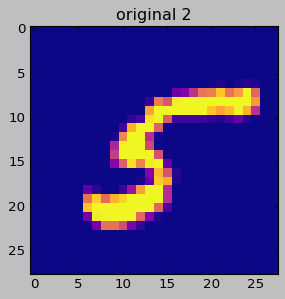

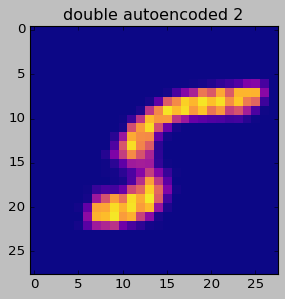

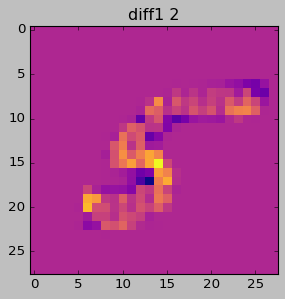

------------------------- IMAGE 3 --------------------------


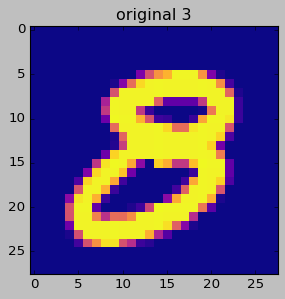

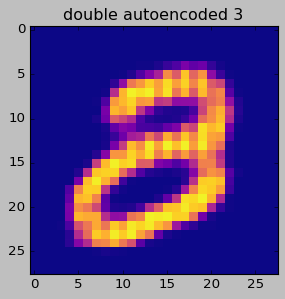

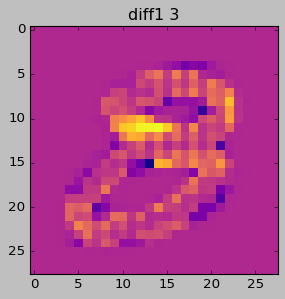

------------------------- IMAGE 4 --------------------------


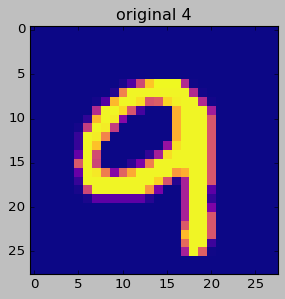

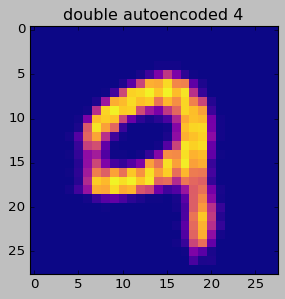

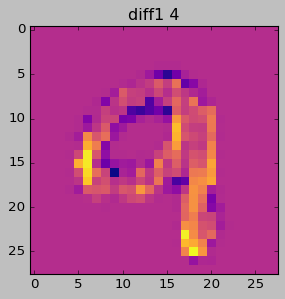

In [14]:
images1_bar = unit1.down(reconstructed_images2, 2)

for i in range(5):
  print(f"------------------------- IMAGE {i} --------------------------")
  show_image(images1[i].detach(), vmin=0, vmax=1, title=f"original {i}")
  show_image(images1_bar[i].detach(), vmin=0, vmax=1, title=f"double autoencoded {i}")
  show_image(images1[i].float().cpu()-images1_bar[i].detach().cpu(), title=f"diff1 {i}")

